In [210]:
import matplotlib.pyplot as plt

def get_centered_limits(data_list, margin_ratio=0.1):
    flat_data = [value for sublist in data_list for value in sublist]
    data_mean = sum(flat_data) / len(flat_data)
    max_dev = max(abs(data_mean - min(flat_data)), abs(data_mean - max(flat_data)))
    max_dev *= (1 + margin_ratio)  # Optional padding
    return (data_mean - max_dev, data_mean + max_dev)

def get_time(data):
    s = 0
    start_ms = data[0][1]
    ms_prev = 999
    
    for i in range(len(data)):
        ms = data[i][1] - start_ms
        if ms < ms_prev:
            s += 1
        ms_prev = ms

    if ms < 0:
        s -= 1
        ms += 1000
    return s + ms / 1000.0

def plot(dataset):
    vicon_command = dataset[0]
    data = dataset[1:]
    
    total_time = get_time(data)
    num_points = len(data)
    time_values = [i * (total_time / num_points) for i in range(num_points)]  # Distribute time evenly across points



    column_labels = ['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']
    y_axis_labels = ['Position [m]', 'Angle [rad]']
    title_text = [' Position', ' Orientation']

    # Compute centered limits with margin
    position_limits = get_centered_limits([entry[2:5] for entry in data])
    orientation_limits = get_centered_limits([entry[5:8] for entry in data])

    # Create 2x3 subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, label in enumerate(column_labels):
        component_data = [entry[i + 2] for entry in data]
        axes[i].plot(time_values, component_data, marker='o', linestyle='-', markersize=1, label=label)
        axes[i].set_title(label + title_text[i // 3], fontsize=14)
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(y_axis_labels[i // 3])
        axes[i].legend()
        axes[i].grid(True)

        # Apply shared, centered Y-axis limits
        if i < 3:  # X, Y, Z
            axes[i].set_ylim(position_limits)
        else:      # Roll, Pitch, Yaw
            axes[i].set_ylim(orientation_limits)

    # Add global title
    fig.suptitle(f"{vicon_command}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [211]:
mcap_path =  "RosBags/PIDTEST0805V4/PIDTEST0805V4_0.mcap" # ex. "RosBags/PIDTEST0805V4/PIDTEST0805V4_0.mcap"

In [212]:
from mcap_ros2.reader import read_ros2_messages
from pathlib import Path
import os

base_path = Path(os.getcwd()).parent
mcap_full_path = base_path / mcap_path

grouped_msgs = []
change_pos = []
i = 0

with open(mcap_full_path, "rb") as f:
    current_group = None
    for msg in read_ros2_messages(f):
        topic = msg.channel.topic
        
        if topic == "/rosout":
            if not grouped_msgs or msg.ros_msg.msg != (grouped_msgs[-1][0]):
                current_group = [msg.ros_msg.msg]
                grouped_msgs.append(current_group)
                
                if 'Starting goal position' in msg.ros_msg.msg:
                    change_pos.append(i)
                i += 1

        elif topic == "/Vicon" and current_group is not None:
            current_group.append(msg.ros_msg.data)


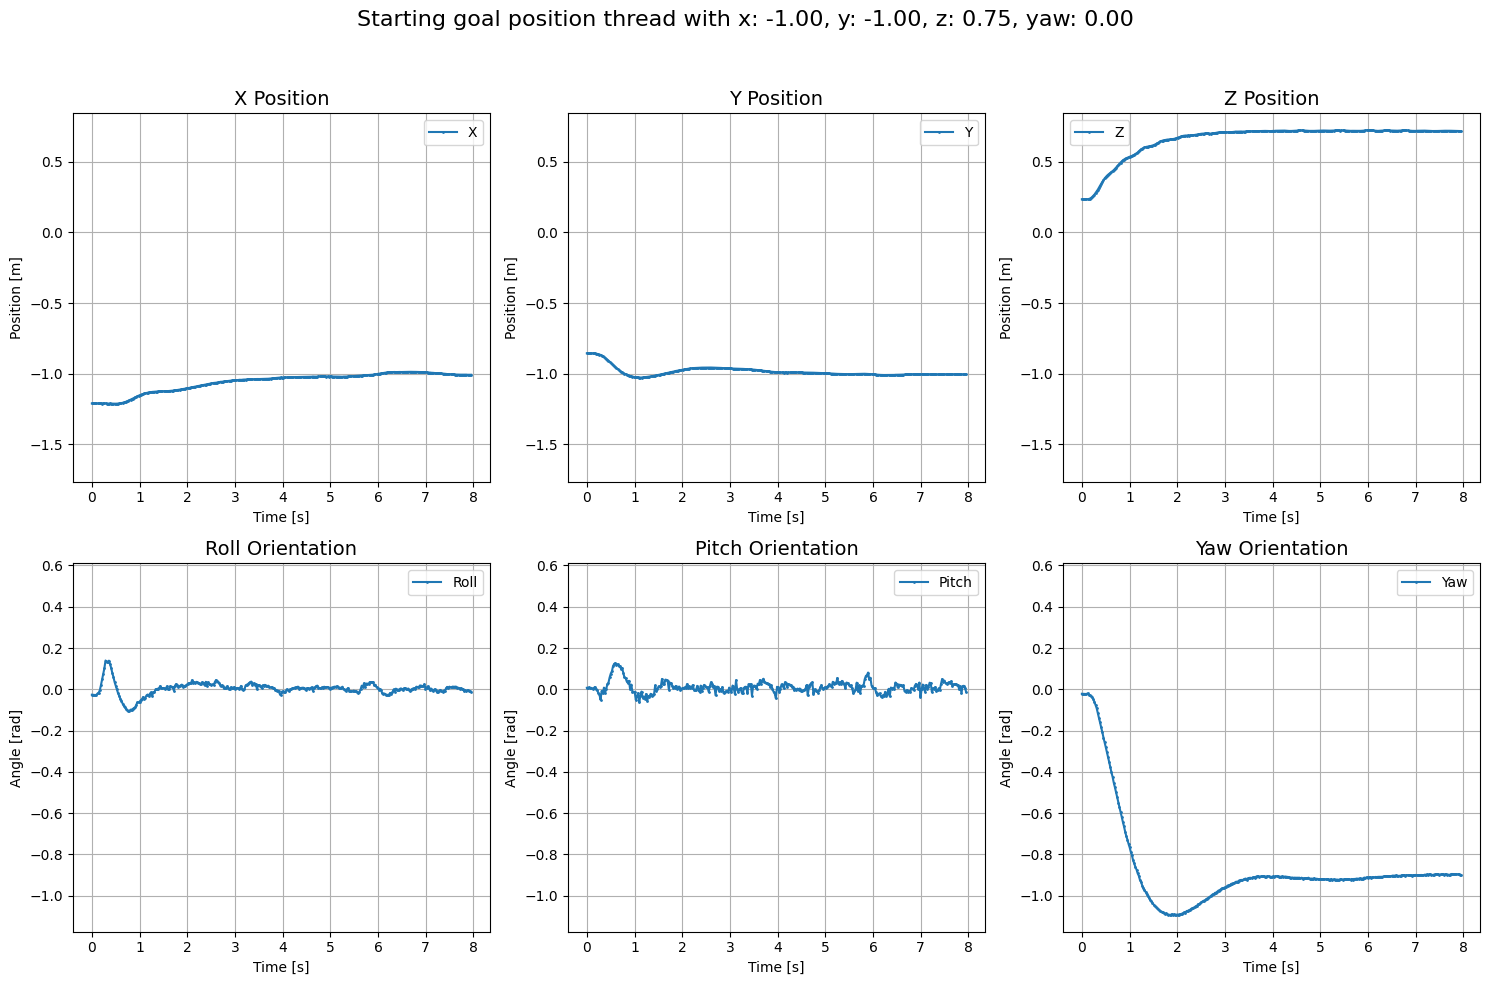

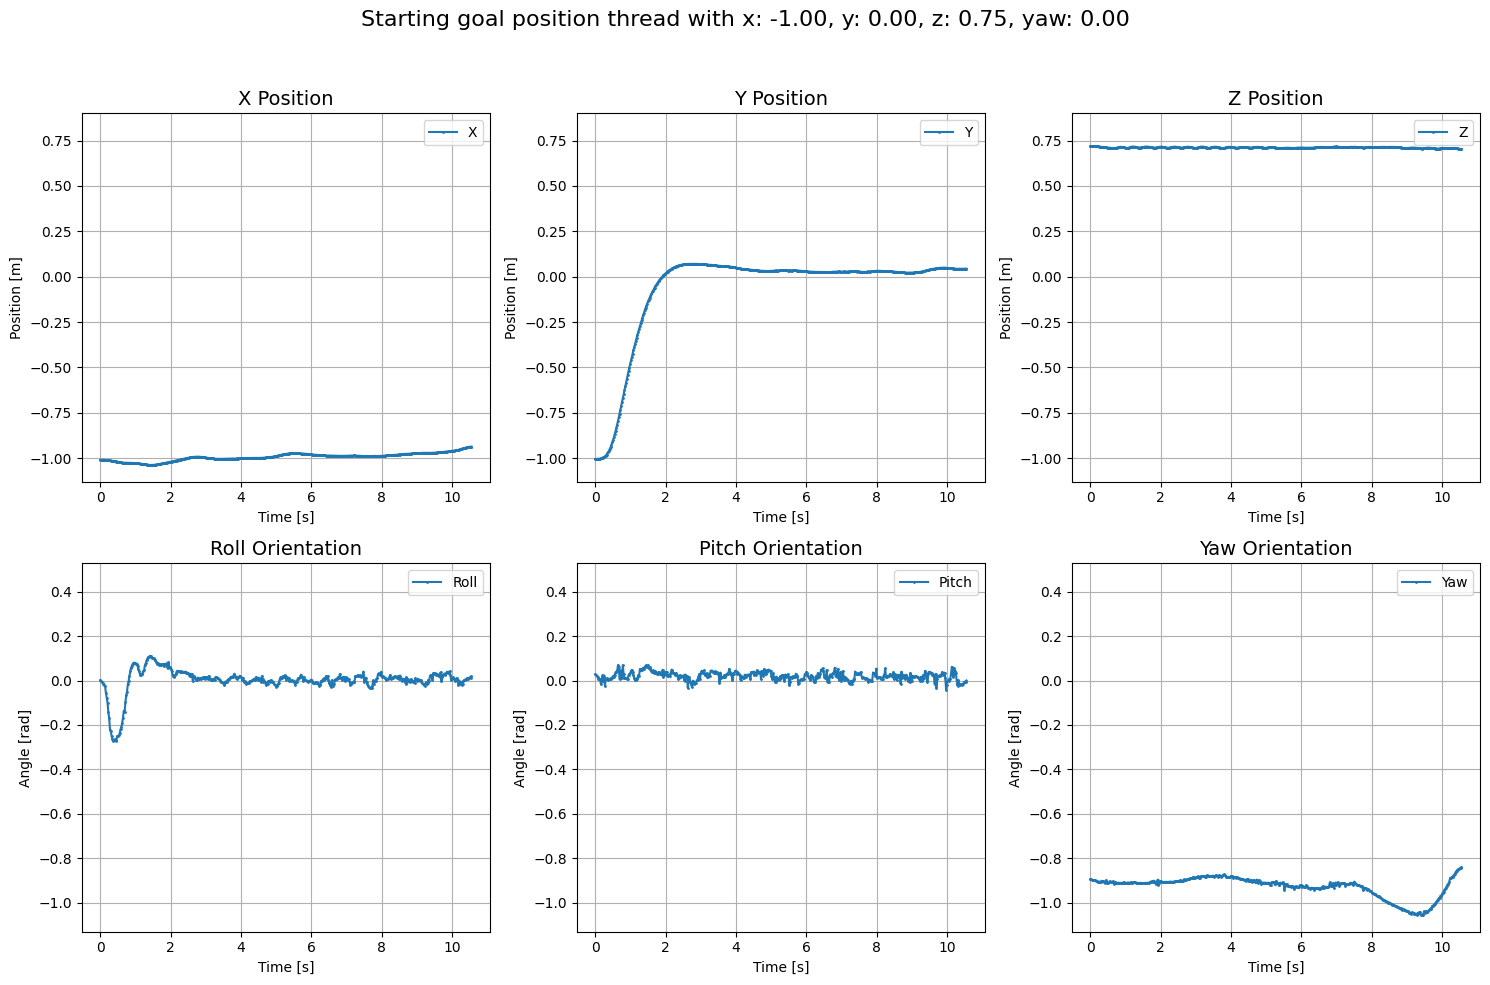

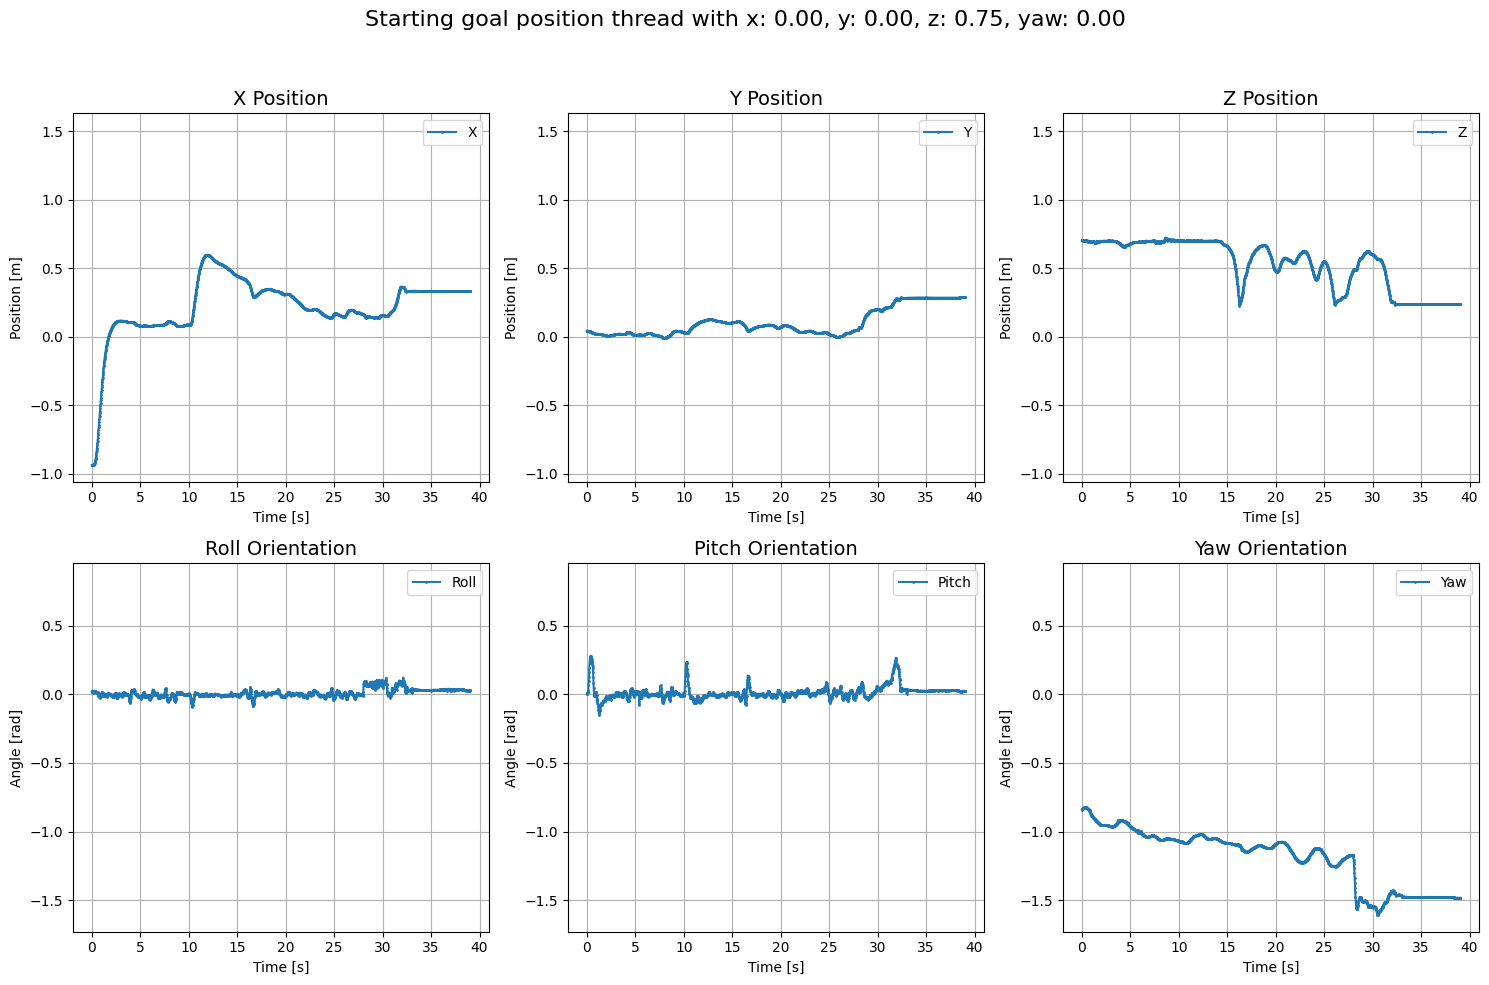

In [213]:
for data in change_pos:
    plot(grouped_msgs[data])


In [ ]:
#csv file

import pandas as pd
from pathlib import Path
import os

base_path = Path(os.getcwd()).parent

test_turnoff_path = ["RosBags\\PIDV1.csv",
                     "RosBags\\PIDV2.csv",
                     "RosBags\\PIDV3.csv"]

test_turnoff = [[] for _ in range(len(test_turnoff_path))]
for i, test_path in enumerate(test_turnoff_path):
    test_path = base_path / test_path
    data = pd.read_csv(test_path)
    print(data.columns)

    for j in range(8):
        test_turnoff[i].append(data[f'/Vicon/data[{j}]'].dropna())


total_packages = len(test_turnoff[0][0])
time_s = get_time(test_turnoff[0])

package_s = time_s / total_packages
